In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
import os 
from glob import glob
import random
import numpy as np

In [3]:
os.listdir("dataset/200622_dataset_3labels/train")

['1', '2', '0']

In [4]:
train_dir = "dataset/200622_dataset_3labels/train" 
test_dir = "dataset/200622_dataset_3labels/test"

# fit 데이터셋 만들기

In [5]:
train_path = glob(train_dir+"/*/*.jpg")
test_path = glob(test_dir+"/*/*.jpg")

In [6]:

random.seed(0)
random.shuffle(train_path)
random.shuffle(test_path)
print(train_path[0])
print(test_path[0])

dataset/200622_dataset_3labels/train/1/aug_3_4_0_6993.jpg
dataset/200622_dataset_3labels/test/0/new_7_wb_CAM1_01568.jpg


In [7]:
def get_label(filepath):
    return filepath.split("/")[-2]

In [8]:
train_x = []
for file in train_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    train_x.append(np.asarray(image))

In [9]:
train_y = [get_label(file) for file in train_path]

In [10]:
test_x = []
for file in test_path:
    gfile = tf.io.read_file(file)
    image = tf.io.decode_image(gfile)
    image = tf.image.resize(image, [50, 50])
    image = tf.image.rgb_to_grayscale(image)
    test_x.append(np.asarray(image))

In [11]:
test_y = [get_label(file) for file in test_path]

In [12]:
train_x[10].shape

(50, 50, 1)

In [13]:
type(train_x[0].shape)
print(type(np.array(train_x[0])))

<class 'numpy.ndarray'>


In [14]:
len(train_y)

48271

In [15]:
np.unique(train_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([16921, 12129, 19221]))

In [16]:
np.unique(test_y, return_counts=True)

(array(['0', '1', '2'], dtype='<U1'), array([3000, 2405, 3000]))

In [17]:
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

In [18]:
train_x = train_x/255
test_x = test_x/255

In [19]:
train_x.shape

(48271, 50, 50, 1)

In [20]:
test_x.shape

(8405, 50, 50, 1)

In [21]:
train_y = train_y.astype("int32")
test_y = test_y.astype("int32")

In [22]:
#train_y = to_categorical(train_y, 3)
#test_y = to_categorical(test_y, 3)

# 모델 정의

In [23]:
input_shape = (50,50,1)
batch_size = 32
learning_rate = 0.0001
# 0.01로 학습했는데 학습 안됨.
dropout_rate = 0.4
num_classes=3
num_epochs=50

In [24]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10
)

In [25]:
inputs = layers.Input(input_shape)
#sequential model에서는 input이 필요 없다
net = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inputs)
net = layers.Conv2D(16, (3,3), padding="same", activation="relu")(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Conv2D(32, (3,3), padding="same", activation="relu")(net)
net = layers.Conv2D(32, (3,3), padding="same", activation="relu")(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Conv2D(64, (3,3), padding="same", activation="relu")(net)
net = layers.Conv2D(64, (3,3), padding="same", activation="relu")(net)

net = layers.Flatten()(net)
net = layers.Dense(128)(net)
net = layers.Activation("relu")(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
#주의: binary classification에서는 output dense가 1이다 
net = layers.Activation("softmax")(net)
#net = layers.Activation("sigmoid")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name="NN")

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:
hist = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping] # decay option
)

Train on 48271 samples, validate on 8405 samples
Epoch 1/50
48271/48271 [==============================] - 69s 1ms/sample - loss: 0.4709 - accuracy: 0.8099 - val_loss: 0.3046 - val_accuracy: 0.8822
Epoch 2/50
48271/48271 [==============================] - 89s 2ms/sample - loss: 0.2700 - accuracy: 0.8994 - val_loss: 0.2230 - val_accuracy: 0.9126
Epoch 3/50
48271/48271 [==============================] - 81s 2ms/sample - loss: 0.2091 - accuracy: 0.9238 - val_loss: 0.1989 - val_accuracy: 0.9247
Epoch 4/50
48271/48271 [==============================] - 90s 2ms/sample - loss: 0.1671 - accuracy: 0.9391 - val_loss: 0.1515 - val_accuracy: 0.9413
Epoch 5/50
48271/48271 [==============================] - 79s 2ms/sample - loss: 0.1394 - accuracy: 0.9510 - val_loss: 0.1466 - val_accuracy: 0.9450
Epoch 6/50
48271/48271 [==============================] - 76s 2ms/sample - loss: 0.1183 - accuracy: 0.9576 - val_loss: 0.0970 - val_accuracy: 0.9672
Epoch 7/50
48271/48271 [==============================] -

# 학습 과정 그래프

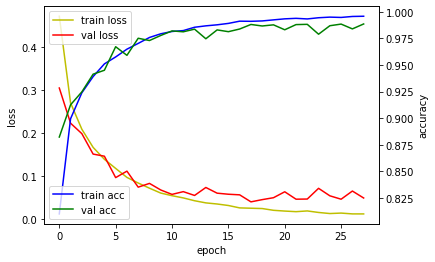

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 모델 저장

In [29]:
#model.save("model/", include_optimizer=True, save_format='tf')
model.save('model/200622-3labels.h5')